## Imports

In [ ]:
!pip install -r requirements.txt

In [ ]:
import torch, enum, time, os, random, math, csv
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn as nn
from mask import *
from process_data import *
from utils import *

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

/workspace/chimera-gpt2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading in and testing model inference

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
prompt = "Help me code up the fibonacci sequence in Python"

max_new_tokens = 100
temperature = 1.0
top_k = 50

generate_text(model, tokenizer, prompt, device, max_new_tokens, temperature, top_k)

 2 or 3. As well as knowing that you can have multiple numbers, you can also do math if you don't already know which key is the right one. After this, the solution will then be stored and processed through the Riemann family for a specific number and we call it the Fibonacci Sequence. Now we will generate the result of the second Fibonacci Sequence with the Fibonacci sequence.

function main(string[] args) { var FibonacciSequence
---
Full output:
Help me code up the fibonacci sequence in Python 2 or 3. As well as knowing that you can have multiple numbers, you can also do math if you don't already know which key is the right one. After this, the solution will then be stored and processed through the Riemann family for a specific number and we call it the Fibonacci Sequence. Now we will generate the result of the second Fibonacci Sequence with the Fibonacci sequence.

function main(string[] args) { var FibonacciSequence


## Loading in txt files

In [ ]:
ds = load_dataset("OpenCoder-LLM/opc-sft-stage2", "educational_instruct", split="train")

In [ ]:
text_ds = ds.remove_columns([c for c in ds.column_names if c != "code"])

In [ ]:
data1 = ""
for i in range(len(text_ds)):
    data1 += text_ds[i]['code']
len(data1)

In [ ]:
data1 = data1[:5337651]

In [ ]:
with open("sample_code.txt", "w") as f:
    f.write(data1)

In [ ]:
with open("data/shakespeare.txt", "r") as f:
    data2 = f.read()
len(data2)

## Creating Datasets

### Creating split datasets

In [ ]:
context = model.config.n_ctx
batch_size = 8

In [ ]:
paths = ['data/shakespeare.txt']

dataset = SimpleTextDataset(paths, tokenizer, context, splits=(0.9, 0.05, 0.05))

train_ds = dataset.get_split(DatasetSplit.train)
val_ds   = dataset.get_split(DatasetSplit.valid)
test_ds  = dataset.get_split(DatasetSplit.test)

train_loader_1 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_1   = DataLoader(val_ds, batch_size=batch_size)
test_loader_1  = DataLoader(test_ds, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (1809728 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
len(train_loader_1), len(val_loader_1), len(test_loader_1)

(199, 11, 12)

In [ ]:
paths = ['data/code.txt']

dataset = SimpleTextDataset(paths, tokenizer, context, splits=(0.9, 0.05, 0.05))

train_ds = dataset.get_split(DatasetSplit.train)
val_ds   = dataset.get_split(DatasetSplit.valid)
test_ds  = dataset.get_split(DatasetSplit.test)

train_loader_2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_2   = DataLoader(val_ds, batch_size=batch_size)
test_loader_2  = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
len(train_loader_2), len(val_loader_2), len(test_loader_2)

(294, 17, 17)

### Creating union dataset

In [ ]:
paths = ['data/shakespeare.txt', 'data/code.txt']

dataset = SimpleTextDataset(paths, tokenizer, context, splits=(0.9, 0.05, 0.05))

train_ds = dataset.get_split(DatasetSplit.train)
val_ds   = dataset.get_split(DatasetSplit.valid)
test_ds  = dataset.get_split(DatasetSplit.test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)


In [ ]:
len(train_loader), len(val_loader), len(test_loader)

(398, 22, 23)

## Training chimera

### Load in Model (must start fine-tuning from pre-trained state)

In [3]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Registering Parametrizations, Getting Masks

In [10]:
# register hooks with split fraction a
# active, masks_1, masks_2 = register_hooks(model, a=0.5)
controller, masks_1, masks_2 = register_parametrizations(model, a=0.5)

### Loop

In [12]:
lr = 3.5e-4
clip = 0.25
epochs = 3
print_interval = 5


===== Epoch 1 =====
 ep       step   elapsed_sec          lr       loss1       ppl1       loss2       ppl2


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  1      5/199          6.25     3.5e-04      6.4848     655.12      5.2939     199.11
  1     10/199          5.34     3.5e-04      5.9144     370.34      4.3011      73.78
  1     15/199          5.34     3.5e-04      5.8320     341.04      3.9421      51.53
  1     20/199          5.35     3.5e-04      5.6804     293.06      3.7623      43.05
  1     25/199          5.36     3.5e-04      5.5239     250.62      3.6810      39.69
  1     30/199          5.36     3.5e-04      5.0850     161.59      3.5989      36.56
  1     35/199          5.37     3.5e-04      4.8429     126.84      3.3654      28.94
  1     40/199          5.37     3.5e-04      4.7921     120.56      3.2740      26.42
  1     45/199          5.37     3.5e-04      4.7976     121.21      3.1992      24.51
  1     50/199          5.38     3.5e-04      4.5920      98.69      2.8698      17.63
  1     55/199          5.38     3.5e-04      4.4698      87.34      2.7514      15.66
  1     60/199          5.39     3.5e-04   

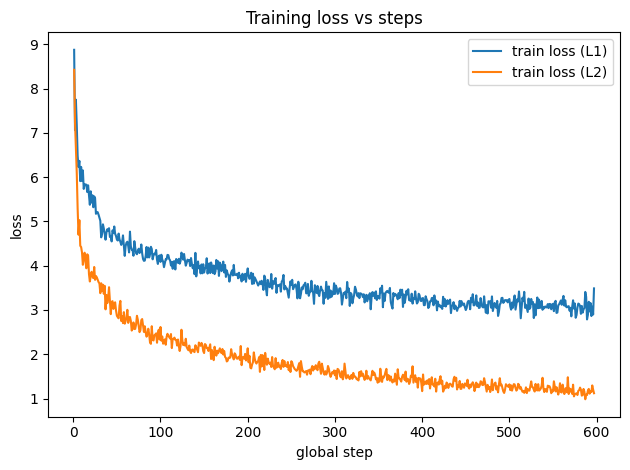

In [ ]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
CKPT_DIR = f"checkpoints/{ts}/"
os.makedirs(CKPT_DIR, exist_ok=True)

LOG_EPOCH = os.path.join(CKPT_DIR, "log.csv")
LOG_STEP = os.path.join(CKPT_DIR, "steps.csv")

with open(LOG_EPOCH, "w") as f:
    f.write("epoch,elapsed_sec,train_loss1,train_ppl1,train_loss2,train_ppl2,val_loss1,val_ppl1,val_loss2,val_ppl2\n")

with open(LOG_STEP, "w") as f:
    f.write("global_step,loss1,loss2\n")

start_time = time.time()
global_step = 0

opt1 = torch.optim.AdamW(model.parameters(),lr=lr,betas=(0.9, 0.95),eps=1e-8,weight_decay=0.01)
opt2 = torch.optim.AdamW(model.parameters(),lr=lr,betas=(0.9, 0.95),eps=1e-8,weight_decay=0.01)

try:
    # step-level and log-level accumulators
    loss_steps1 = []
    loss_steps2 = []
    step_index  = []

    for epoch in range(1, epochs + 1):
        print(f"\n===== Epoch {epoch} =====")
        model.train()
        t_batch = time.time()

        # epoch-level accumulators
        train_loss1_tokensum = 0.0
        train_loss2_tokensum = 0.0
        train_tokens1 = 0
        train_tokens2 = 0

        eff_train_len = min(len(train_loader_1), len(train_loader_2))

        print(f"{'ep':>3}{'step':>11}{'elapsed_sec':>14}{'lr':>12}"
              f"{'loss1':>12}{'ppl1':>11}{'loss2':>12}{'ppl2':>11}")

        for step, ((x1, y1), (x2, y2)) in enumerate(zip(train_loader_1, train_loader_2), start=1):
            x1, y1 = x1.to(device), y1.to(device)
            x2, y2 = x2.to(device), y2.to(device)

            # pass 1 (dataset 1)
            controller.set_active("L1")
            opt1.zero_grad(set_to_none=True)
            out1 = model(x1, labels=y1)
            out1.loss.backward()
            opt1.step()

            # pass 2 (dataset 2)
            controller.set_active("L2")
            opt2.zero_grad(set_to_none=True)
            out2 = model(x2, labels=y2)
            out2.loss.backward()
            opt2.step()

            l1 = out1.loss.item()
            l2 = out2.loss.item() 
            loss_steps1.append(l1)
            loss_steps2.append(l2)
            step_index.append(global_step + 1)

            train_loss1_tokensum += l1 * x1.numel()
            train_tokens1 += x1.numel()
            train_loss2_tokensum += l2 * x2.numel()
            train_tokens2 += x2.numel()

            global_step += 1

            if (step % print_interval) == 0:
                elapsed_s = (time.time() - t_batch)

                print(f"{epoch:3d}{step:7d}/{eff_train_len:<6d}{elapsed_s:11.2f}{lr:12.1e}"
                      f"{l1:12.4f}{math.exp(l1):11.2f}{l2:12.4f}{math.exp(l2):11.2f}")

                t_batch = time.time()

        # ---------- epoch end aggregates ----------
        epoch_train_loss1 = train_loss1_tokensum / max(1, train_tokens1)
        epoch_train_loss2 = train_loss2_tokensum / max(1, train_tokens2)
        epoch_train_ppl1 = math.exp(epoch_train_loss1)
        epoch_train_ppl2 = math.exp(epoch_train_loss2)

        # ---------- evaluation AFTER training ----------
        t0 = time.time()
        eff_val_len = min(len(val_loader_1), len(val_loader_2))
        val_loss_1 = evaluate_c(val_loader_1, model, controller, device, max_batches=eff_val_len)
        val_loss_2 = evaluate_c(val_loader_2, model, controller, device, max_batches=eff_val_len)
        eval_time = time.time() - t0

        print('-' * 100)
        print(f'| epoch: {epoch:3d} | eval_time: {eval_time:.2f}s | '
              f'val1: {val_loss_1:.3f} (ppl: {math.exp(val_loss_1):.2f}) | '
              f'val2: {val_loss_2:.3f} (ppl: {math.exp(val_loss_2):.2f})')
        print('-' * 100)

        # ---------- checkpointing ----------
        # save latest model
        torch.save({
            "model_state": model.state_dict(),
            "val_loss_1": val_loss_1,
            "val_loss_2": val_loss_2,
            "train_loss_1": epoch_train_loss1,
            "train_loss_2": epoch_train_loss2,
        }, os.path.join(CKPT_DIR, f"latest.pt"))

        torch.save({
            "model_state": model.state_dict(),
            "val_loss_1": val_loss_1,
            "val_loss_2": val_loss_2,
            "train_loss_1": epoch_train_loss1,
            "train_loss_2": epoch_train_loss2,
        }, os.path.join(CKPT_DIR, f"epoch_{epoch}.pt"))

        # ---------- epoch log row ----------
        elapsed_sec = time.time() - start_time
        with open(LOG_EPOCH, "a") as f:
            f.write(f"{epoch},{elapsed_sec:.2f},"
                    f"{epoch_train_loss1:.6f},{epoch_train_ppl1:.4f},"
                    f"{epoch_train_loss2:.6f},{epoch_train_ppl2:.4f},"
                    f"{val_loss_1:.6f},{math.exp(val_loss_1):.4f},"
                    f"{val_loss_2:.6f},{math.exp(val_loss_2):.4f}\n")
            
    plt.figure()
    plt.plot(step_index, loss_steps1, label="train loss (L1)")
    plt.plot(step_index, loss_steps2, label="train loss (L2)")
    plt.xlabel("global step")
    plt.ylabel("loss")
    plt.title("Training loss vs steps")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CKPT_DIR, "loss_vs_steps.png"), dpi=150)
    print(f"Saved plot to {os.path.join(CKPT_DIR, 'loss_vs_steps.png')}")

    with open(LOG_STEP, "w") as f:
        for s, a, b in zip(step_index, loss_steps1, loss_steps2):
            f.write(f"{s},{a:.6f},{b:.6f}\n")

except KeyboardInterrupt:
    print('Graceful Exit')

## Regular fine-tuning

### Load in Model (must start fine-tuning from pre-trained state)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Loop

In [ ]:
lr = 3.5e-4
clip = 0.25
epochs = 3
print_interval = 10

In [ ]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
CKPT_DIR = f"checkpoints/{ts}/"
os.makedirs(CKPT_DIR, exist_ok=True)

LOG_EPOCH = os.path.join(CKPT_DIR, "log.csv")
LOG_STEP = os.path.join(CKPT_DIR, "steps.csv")

with open(LOG_EPOCH, "w") as f:
    f.write("epoch,elapsed_sec,train_loss,train_ppl,val_loss,val_ppl\n")

with open(LOG_STEP, "w") as f:
    f.write("global_step,loss\n")

start_time = time.time()
global_step = 0

opt = torch.optim.AdamW(model.parameters(),lr=lr,betas=(0.9, 0.95),eps=1e-8,weight_decay=0.01)

try:
    # step-level and log-level accumulators
    loss_steps = []
    step_index  = []

    for epoch in range(1, epochs + 1):
        print(f"\n===== Epoch {epoch} =====")
        model.train()
        t_batch = time.time()

        # epoch-level accumulators
        train_loss_tokensum = 0.0
        train_tokens = 0

        print(f"{'ep':>3}{'step':>11}{'elapsed_sec':>14}{'lr':>12}"
              f"{'loss':>12}{'ppl':>11}")

        for step, (x,y) in enumerate((train_loader), start=1):
            x, y = x.to(device), y.to(device)

            opt.zero_grad(set_to_none=True)
            out = model(x, labels=y)
            out.loss.backward()
            opt.step()

            l = out.loss.item()
            loss_steps.append(l)
            step_index.append(global_step + 1)

            train_loss_tokensum += l * x.numel()
            train_tokens += x.numel()

            global_step += 1

            if (step % print_interval) == 0:
                elapsed_s = (time.time() - t_batch)

                print(f"{epoch:3d}{step:7d}/{len(train_loader):<6d}{elapsed_s:11.2f}{lr:12.1e}"
                      f"{l:12.4f}{math.exp(l):11.2f}")

                t_batch = time.time()

        # ---------- epoch end aggregates ----------
        epoch_train_loss = train_loss_tokensum / max(1, train_tokens)
        epoch_train_ppl = math.exp(epoch_train_loss)

        # ---------- evaluation AFTER training ----------
        t0 = time.time()

        # still test on L1 and L2 separately
        eff_val_len = min(len(val_loader_1), len(val_loader_2))
        val_loss_1 = evaluate(val_loader_1, model, device, max_batches=eff_val_len)
        val_loss_2 = evaluate(val_loader_2, model, device, max_batches=eff_val_len)
        eval_time = time.time() - t0

        print('-' * 100)
        print(f'| epoch: {epoch:3d} | eval_time: {eval_time:.2f}s | '
              f'val1: {val_loss_1:.3f} (ppl: {math.exp(val_loss_1):.2f}) | '
              f'val2: {val_loss_2:.3f} (ppl: {math.exp(val_loss_2):.2f})')
        print('-' * 100)

        # ---------- checkpointing ----------
        # save latest model
        torch.save({
            "model_state": model.state_dict(),
            "val_loss_1": val_loss_1,
            "val_loss_2": val_loss_2,
            "train_loss": epoch_train_loss,
        }, os.path.join(CKPT_DIR, f"latest.pt"))

        torch.save({
            "model_state": model.state_dict(),
            "val_loss_1": val_loss_1,
            "val_loss_2": val_loss_2,
            "train_loss": epoch_train_loss,
        }, os.path.join(CKPT_DIR, f"epoch_{epoch}.pt"))

        # ---------- epoch log row ----------
        elapsed_sec = time.time() - start_time
        with open(LOG_EPOCH, "a") as f:
            f.write(f"{epoch},{elapsed_sec:.2f},"
                    f"{epoch_train_loss:.6f},{epoch_train_ppl:.4f},"
                    f"{val_loss_1:.6f},{math.exp(val_loss_1):.4f},"
                    f"{val_loss_2:.6f},{math.exp(val_loss_2):.4f}\n")
            
    plt.figure()
    plt.plot(step_index, loss_steps, label="train loss")
    plt.xlabel("global step")
    plt.ylabel("loss")
    plt.title("Training loss vs steps")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CKPT_DIR, "loss_vs_steps.png"), dpi=150)
    print(f"Saved plot to {os.path.join(CKPT_DIR, 'loss_vs_steps.png')}")

    with open(LOG_STEP, "w") as f:
        for s, a, b in zip(step_index, loss_steps):
            f.write(f"{s},{a:.6f},{b:.6f}\n")

except KeyboardInterrupt:
    print('Graceful Exit')

## Testing Model

In [ ]:
ckpt_path = "checkpoints/20251106_024828/best.pt"

print(f"\n[TEST] Loading checkpoint from: {ckpt_path}")
ckpt = torch.load(ckpt_path, map_location=device)
state_dict = ckpt.get("model_state", ckpt)

model.load_state_dict(state_dict, strict=False)
model.to(device)

In [ ]:
eff_test_len = min(len(test_loader_1), len(test_loader_2))
test_loss_1 = evaluate(test_loader_1, model, controller, device, max_batches=eff_test_len)
test_ppl_1  = math.exp(test_loss_1)
test_loss_2 = evaluate(test_loader_2, model, controller, device, max_batches=eff_test_len)
test_ppl_2  = math.exp(test_loss_2)

print("-" * 100)
print(f"| TEST @ {os.path.basename(ckpt_path)} | "
      f"loss1: {test_loss_1:.4f} (ppl {test_ppl_1:.2f}) | "
      f"loss2: {test_loss_2:.4f} (ppl {test_ppl_2:.2f})")
print("-" * 100)

----------------------------------------------------------------------------------------------------
| TEST @ best_2.pt | loss1: 2.8741 (ppl 17.71) | loss2: 0.6462 (ppl 1.91)
----------------------------------------------------------------------------------------------------
